# Simple Variational Autoencoders (VAEs)

https://en.wikipedia.org/wiki/Variational_autoencoder

Note It only works with numpy<2 then tensorflow has to be <2.18 
!pip install tensorflow==2.17.0

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import pandas as pd
from scipy.stats import spearmanr, pearsonr, chi2_contingency, normaltest, mstats
from sklearn.metrics import mutual_info_score
import warnings
warnings.filterwarnings("ignore")

## The Data

In [30]:
# Load the dataset (replace 'your_dataset.csv' with your actual file)
data = pd.read_csv('users_summary.csv')

# Preprocess the data
epsilon = 1e-10
log_data = np.log1p(data + epsilon)
normalized_data = pd.DataFrame(MinMaxScaler().fit_transform(log_data), columns=log_data.columns)
normalized_data = normalized_data.drop("user_id", axis=1)

1. Visualize distributions of each column


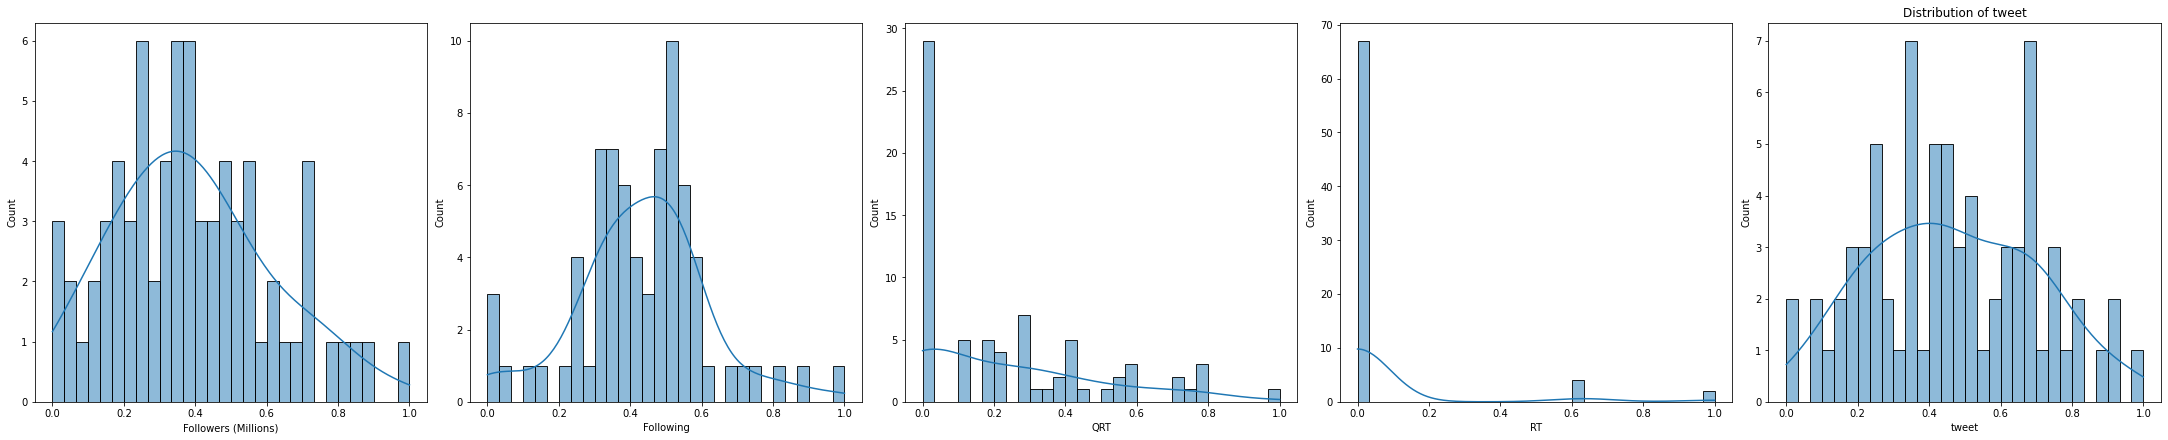

In [31]:
print("1. Visualize distributions of each column")
def plot_distributions(data):
    fig, axes = plt.subplots(1, len(data.columns), figsize=(6 * len(data.columns), 6), constrained_layout=True)
    for i, col in enumerate(data.columns):
        ax = axes[i]
        sns.histplot(data[col], kde=True, bins=30, ax=ax)
        plt.title(f"Distribution of {col}")
plot_distributions(normalized_data)


2. Check pairwise correlations


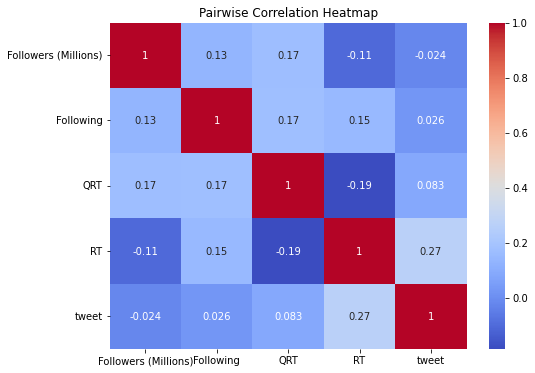

In [27]:
print("\n2. Check pairwise correlations")
def compute_correlations(data):
    plt.figure(figsize=(8, 6))
    corr_matrix = data.corr(method='pearson')  # Pearson correlation
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title("Pairwise Correlation Heatmap")
    plt.show()

compute_correlations(normalized_data)

In [28]:
print("\n3. Multivariate normality test (Mardia's test approximation)")
def multivariate_normality(data):
    standardized_data = StandardScaler().fit_transform(data)
    skewness = np.mean((standardized_data**3).sum(axis=1))
    kurtosis = np.mean((standardized_data**4).sum(axis=1)) - 3
    print(f"Mardia Test Results:\nSkewness: {skewness}\nKurtosis: {kurtosis}")

multivariate_normality(normalized_data)
print("""
The results show that the data does not conform to a multivariate normal distribution. 
""")
multivariate_normality(normalized_data[['Followers (Millions)', 'Following']])
print("""
When only 'Followers (Millions)', 'Following' are taken into account, appears to 
follow a multivariate normal distribution.
""")
multivariate_normality(normalized_data[['Followers (Millions)', 'Following', 'tweet']])
print("""
When only 'Followers (Millions)', 'Following' AND 'tweet' are taken into account, it moves apart from
the multivariate normal distribution.
""")


3. Multivariate normality test (Mardia's test approximation)
Mardia Test Results:
Skewness: 4.999358335414927
Kurtosis: 22.346378753783686

The results show that the data does not conform to a multivariate normal distribution. 

Mardia Test Results:
Skewness: 0.5619275395983665
Kurtosis: 3.953585015561754

When only 'Followers (Millions)', 'Following' are taken into account, appears to 
follow a multivariate normal distribution.

Mardia Test Results:
Skewness: 0.6985227939505528
Kurtosis: 6.234275470290255

When only 'Followers (Millions)', 'Following' AND 'tweet' are taken into account, it moves apart from
the multivariate normal distribution.



In [36]:
print("\n4. Mutual Information for non-linear relationships")
def test_independence(data):
    print("\nTesting Column Independence:")
    for col1 in data.columns:
        for col2 in data.columns:
            if col1 != col2:
                # Mutual Information
                mi = mutual_info_score(data[col1], data[col2])
                print(f"Mutual Information between {col1} and {col2}: {mi:.4f}")

test_independence(normalized_data)


4. Mutual Information for non-linear relationships

Testing Column Independence:
Mutual Information between Followers (Millions) and Following: 4.2073
Mutual Information between Followers (Millions) and QRT: 2.4521
Mutual Information between Followers (Millions) and RT: 0.3174
Mutual Information between Followers (Millions) and tweet: 4.1955
Mutual Information between Following and Followers (Millions): 4.2073
Mutual Information between Following and QRT: 2.4259
Mutual Information between Following and RT: 0.3364
Mutual Information between Following and tweet: 4.1883
Mutual Information between QRT and Followers (Millions): 2.4521
Mutual Information between QRT and Following: 2.4259
Mutual Information between QRT and RT: 0.1119
Mutual Information between QRT and tweet: 2.4141
Mutual Information between RT and Followers (Millions): 0.3174
Mutual Information between RT and Following: 0.3364
Mutual Information between RT and QRT: 0.1119
Mutual Information between RT and tweet: 0.3364
Mutu

## The Model

In [44]:
class VAE(keras.Model):
    def __init__(self, input_dim, latent_dim, reconstruction_param, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = self.encoder(input_dim)
        self.decoder = self.decoder(input_dim, latent_dim)
        self.reconstruction_param = reconstruction_param
        
    def encoder(self, input_dim):
        encoder_inputs = tf.keras.Input(shape=(input_dim,))
        x = layers.Dense(12, activation='relu', kernel_initializer='he_normal')(encoder_inputs)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(12, activation='relu')(x)
        z_mean = layers.Dense(latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
        return encoder

    # Define the decoder
    def decoder(self, input_dim, latent_dim):
        latent_inputs = tf.keras.Input(shape=(latent_dim,))
        x = layers.Dense(12, activation='relu')(latent_inputs)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(12, activation='relu')(x)
        decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(x)
        decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        return decoder
        
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling((z_mean, z_log_var))
            tf.print("z:", tf.reduce_mean(z))
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= data.shape[1]
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -tf.reduce_mean(kl_loss)
            
            total_loss = (self.reconstruction_param * reconstruction_loss + (1-self.reconstruction_param) * kl_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean, z_log_var = self.encoder(data)
        z = self.sampling((z_mean, z_log_var))
        return self.decoder(z)

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        sampled_z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return sampled_z

class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.kl_loss = []
        self.reconstruction_loss = []
        self.total_loss = []

    def on_epoch_end(self, epoch, logs=None):
        self.kl_loss.append(logs['kl_loss'])
        self.reconstruction_loss.append(logs['reconstruction_loss'])
        self.total_loss.append(logs['loss'])

In [45]:
def plot_prob_distr(data, title):
    # Get all pairwise combinations of columns
    combinations = np.array(list(itertools.combinations(range(data.shape[1]), 2)))
    num_combinations = len(combinations)
    max_plots_per_row = 5
    
    # Compute number of rows required
    num_rows = (num_combinations + max_plots_per_row - 1) // max_plots_per_row  # Ceiling division
    
    # Create subplots grid
    fig, axes = plt.subplots(
        num_rows, 
        min(max_plots_per_row, num_combinations), 
        figsize=(3 * min(max_plots_per_row, num_combinations), 3 * num_rows), 
        constrained_layout=True
    )
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes array for easy indexing
    axes = np.array(axes).flatten()
    
    # Loop over each pair of columns
    for i, comb in enumerate(combinations):
        ax = axes[i]  # Select the appropriate subplot
        sns.kdeplot(
            x=data[:, comb[0]], 
            y=data[:, comb[1]], 
            cmap="Blues", 
            fill=True, 
            ax=ax
        )
        ax.scatter(data[:, comb[0]], data[:, comb[1]], alpha=0.5, s=8)
        ax.set_xlabel(f'Feature {comb[0]}')
        ax.set_ylabel(f'Feature {comb[1]}')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(f'Feature {comb[0]} vs Feature {comb[1]}')

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.show()

## The implementation

### Train with fake generated data

Note that the data are vectors. Each agent will be described by a single vector such as:
- [frequency_of_posting, probability of engagement, topic_preference_music, topic_preference_sports]
- [0.5, 0.2, 0.7, 0.3]

In [46]:
input_dim = 5
latent_dim = 2

data = np.genfromtxt('users_summary.csv', delimiter=',', skip_header=1, usecols=range(1, input_dim+1))#, usecols=[1,2,5]

# Add a small constant to handle zeros
epsilon = 1e-10
log_data = np.log1p(data + epsilon)
normalized_data = MinMaxScaler().fit_transform(log_data)
normalized_data = np.round(normalized_data, 2)

X_train, X_test = train_test_split(normalized_data, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (58, 5)
Test data shape: (15, 5)


In [47]:
%%capture
vae = VAE(input_dim, latent_dim, 0.98)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01))
loss_history = LossHistory()
vae.fit(X_train, epochs=1000, batch_size=128, callbacks=[loss_history])

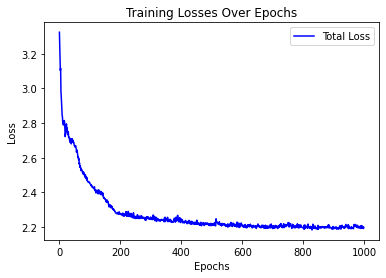

In [48]:
# Plot the losses after training
plt.plot(loss_history.total_loss,'b', label="Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses Over Epochs")
plt.show()

### Validate Reconstruction

Original X_test sample:
 [[0.27 0.34 0.   0.   0.21]
 [0.32 0.22 0.12 0.   0.61]
 [0.85 0.31 0.   0.   0.59]]
Reconstructed X_test sample:
 [[0.44 0.33 0.01 0.   0.17]
 [0.25 0.37 0.06 0.   0.61]
 [0.65 0.5  0.   0.   0.69]]


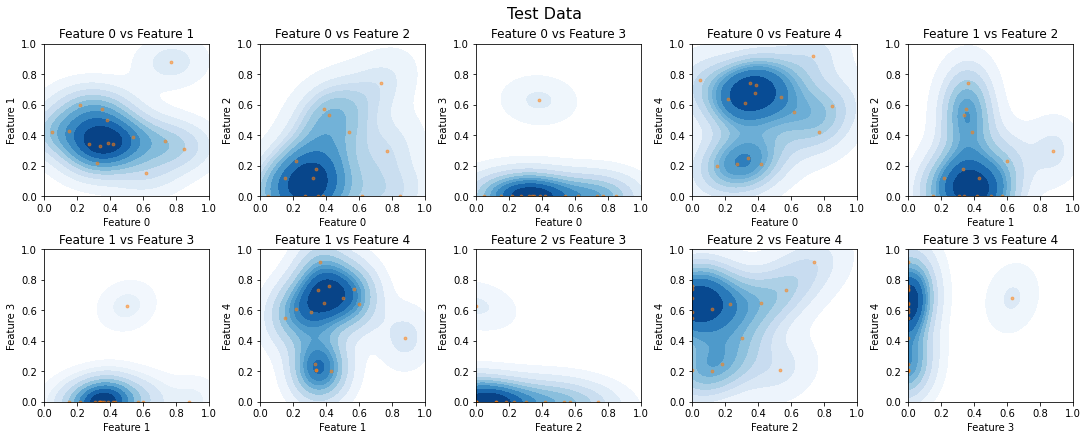

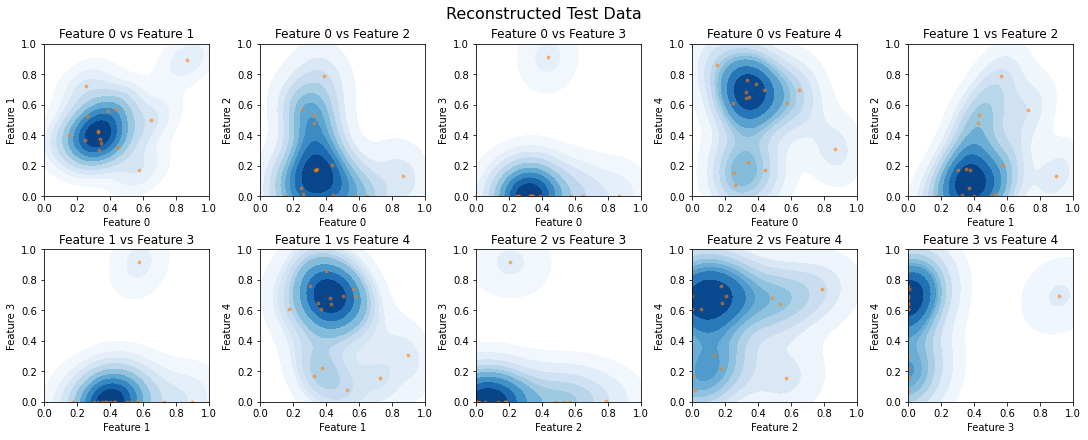

In [49]:
# Validate on X_test
# Get the mean and log variance from the encoder
z_mean, z_log_var = vae.encoder(X_test)
# Sample z from the mean and log variance
z_sample = vae.sampling((z_mean, z_log_var))
# Decode the latent vector to get the reconstructed data
X_test_reconstructed = vae.decoder(z_sample)

# Display original and reconstructed samples for comparison
print("Original X_test sample:\n", X_test[:3])
print("Reconstructed X_test sample:\n", np.round(X_test_reconstructed[:3].numpy(), 2))
plot_prob_distr(X_test, "Test Data")
plot_prob_distr(X_test_reconstructed, "Reconstructed Test Data")

### Generate New Agents

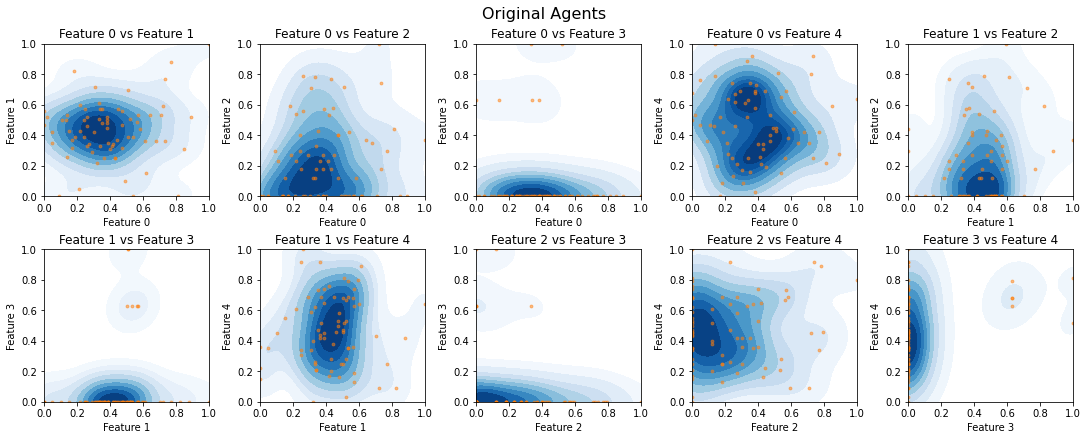

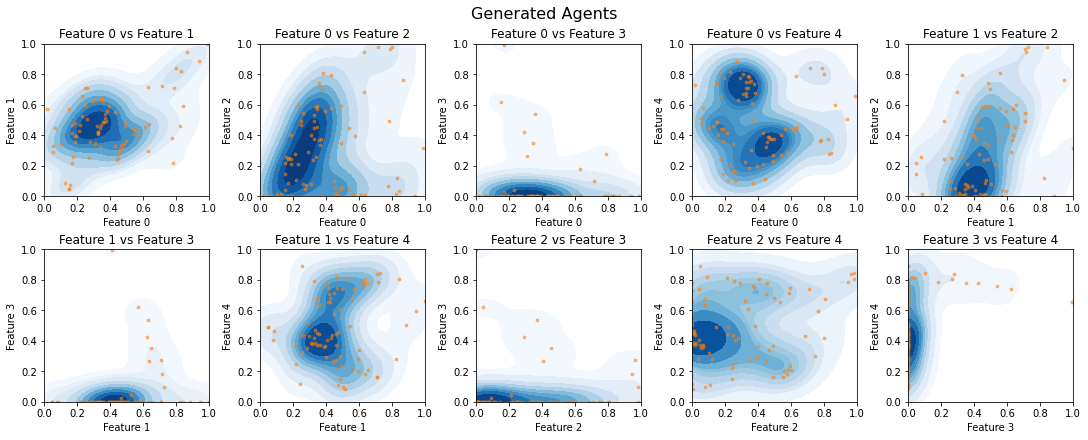

In [50]:
def generate_new_vectors(vae, num_samples):
    latent_samples = tf.random.normal(shape=(num_samples, latent_dim))
    generated_vectors = vae.decoder(latent_samples)
    return generated_vectors.numpy()

new_vectors = generate_new_vectors(vae, num_samples=80)

plot_prob_distr(normalized_data, "Original Agents")
plot_prob_distr(new_vectors, "Generated Agents")